### Import dependencies 

In [1]:
import pandas as pd
import numpy as np
import pickle

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import Concatenate

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dropout
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import time

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the dataset from the original publication

In [3]:
DF_MRI = pd.read_excel(open('./datasets/Dataset 2.xlsx', 'rb'),
              sheet_name='Data organized fluoro-monomer')  

In [4]:
DF_MRI

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b
0,0.00,0.00,0.10,0.90,0.00,0.00,20,0.036740,-,-
1,0.00,0.00,0.20,0.30,0.00,0.50,47,0.117168,7100,1.25
2,0.00,0.00,0.20,0.30,0.50,0.00,61,0.127174,8100,1.16
3,0.00,0.00,0.20,0.40,0.00,0.40,46,0.105659,7800,1.26
4,0.00,0.00,0.20,0.40,0.40,0.00,51,0.112017,-,-
...,...,...,...,...,...,...,...,...,...,...
413,0.65,0.00,0.00,0.15,0.15,0.05,X,0.187427,-,-
414,0.70,0.00,0.00,0.30,0.00,0.00,55,0.158419,-,-
415,0.75,0.00,0.00,0.00,0.05,0.20,X,0.277993,-,-
416,0.80,0.00,0.00,0.10,0.00,0.10,X,0.243231,-,-


### Construct the summary table

In [5]:
TFEA = 'C(OC(=O)C(C[*])[*])C(F)(F)F'
HexaFOEA = 'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F'
NonaFOEA = 'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F'
PEGA = 'O(C(=O)C(C[*])[*])CCOC'
HEA = 'O(C(=O)C(C[*])[*])CCO[H]'
MSEA = 'O(C(=O)C(C[*])[*])CC[S](C)=O'

In [6]:
Flag = [i != 'X' for i in DF_MRI['19F NMR Signal-to-Noise Ratioa']]

In [7]:
DF_MRI[Flag]

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b
0,0.0,0.0,0.1,0.9,0.0,0.0,20,0.036740,-,-
1,0.0,0.0,0.2,0.3,0.0,0.5,47,0.117168,7100,1.25
2,0.0,0.0,0.2,0.3,0.5,0.0,61,0.127174,8100,1.16
3,0.0,0.0,0.2,0.4,0.0,0.4,46,0.105659,7800,1.26
4,0.0,0.0,0.2,0.4,0.4,0.0,51,0.112017,-,-
...,...,...,...,...,...,...,...,...,...,...
408,0.6,0.0,0.0,0.3,0.1,0.0,50,0.137867,4600,1.37
409,0.6,0.0,0.0,0.4,0.0,0.0,31,0.120230,-,-
410,0.6,0.0,0.0,0.4,0.0,0.0,47,0.120230,-,-
411,0.6,0.0,0.0,0.4,0.0,0.0,52,0.120230,-,-


In [8]:
Dataset_2 = DF_MRI[Flag].copy()

In [9]:
Dataset_2['Smiles'] = np.nan
for i in range(len(Dataset_2)):
    smi = 'C'
    if Dataset_2['TFEA'].iloc[i] > 0:
        smi = smi + '.C(OC(=O)C(C[*])[*])C(F)(F)F'
    if Dataset_2['HexaFOEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F'
    if Dataset_2['NonaFOEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F'
    if Dataset_2['PEGA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCOC'
    if Dataset_2['HEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCO[H]'
    if Dataset_2['MSEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CC[S](C)=O'
    Dataset_2['Smiles'].iloc[i] = smi   

C:\Users\let20002\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
Dataset_2

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b,Smiles
0,0.0,0.0,0.1,0.9,0.0,0.0,20,0.036740,-,-,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
1,0.0,0.0,0.2,0.3,0.0,0.5,47,0.117168,7100,1.25,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
2,0.0,0.0,0.2,0.3,0.5,0.0,61,0.127174,8100,1.16,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
3,0.0,0.0,0.2,0.4,0.0,0.4,46,0.105659,7800,1.26,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
4,0.0,0.0,0.2,0.4,0.4,0.0,51,0.112017,-,-,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
...,...,...,...,...,...,...,...,...,...,...,...
408,0.6,0.0,0.0,0.3,0.1,0.0,50,0.137867,4600,1.37,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
409,0.6,0.0,0.0,0.4,0.0,0.0,31,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
410,0.6,0.0,0.0,0.4,0.0,0.0,47,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
411,0.6,0.0,0.0,0.4,0.0,0.0,52,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...


### Feature engineering with Morgan fingerprint

In [11]:
MOL = pd.DataFrame(['C(OC(=O)C(C[*])[*])C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC',
'O(C(=O)C(C[*])[*])CCO[H]',
'O(C(=O)C(C[*])[*])CC[S](C)=O'])[0].apply(Chem.MolFromSmiles)

In [12]:
fp_1 = MOL.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_1_n = fp_1.apply(lambda m: m.GetNonzeroElements())

In [13]:
# using substructures in dataset-1 to construct a dictionary
HashCode = []
for i in fp_1_n:
    for j in i.keys():
        HashCode.append(j)

unique_set = set(HashCode)
unique_list = list(unique_set)

Corr_df = pd.DataFrame(unique_list).reset_index()

In [14]:
#construct dataset-1 input
MY_finger = []
for polymer in fp_1_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        index = Corr_df[Corr_df[0] == key]['index'].values[0]
        my_finger[index] = polymer[key]
    MY_finger.append(my_finger)

MY_finger_dataset = pd.DataFrame(MY_finger)  

In [15]:
MY_finger_dataset

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1,2,0,1,1,2,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,2
2,1,0,0,0,2,0,0,1,3,1,...,1,1,1,1,0,0,0,0,0,0
3,1,0,0,0,2,0,1,0,0,0,...,0,0,1,1,0,0,1,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
5,1,1,0,0,1,0,1,0,0,0,...,0,0,1,1,1,0,0,0,0,0


In [16]:
# filter input into the most popular 124 substructures
Zero_Sum = (MY_finger_dataset == 0).astype(int).sum()
NumberOfZero = 6
print(len(Zero_Sum[Zero_Sum < NumberOfZero]))
X = MY_finger_dataset[Zero_Sum[Zero_Sum < NumberOfZero].index]

80


### CNN

In [17]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)
        
        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = list(X.iloc[0].values)
            elif j in Random_position[1]:
                Sequency_X[j] = list(X.iloc[1].values)
            elif j in Random_position[2]:
                Sequency_X[j] = list(X.iloc[2].values)
            elif j in Random_position[3]:
                Sequency_X[j] = list(X.iloc[3].values)
            elif j in Random_position[4]:
                Sequency_X[j] = list(X.iloc[4].values)
            elif j in Random_position[5]:
                Sequency_X[j] = list(X.iloc[5].values)
                
        Mix_X_100Block.append(Sequency_X)   

Mix_X_100Block = np.array(Mix_X_100Block)

In [18]:
Mix_X_100Block.shape

(271, 100, 80)

In [19]:
Mix_X_100Block

array([[[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       ...,

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0]],

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 

In [20]:
Mix_X_100Block = Mix_X_100Block.reshape((271, 100, 80, 1))
Mix_X_100Block.shape

(271, 100, 80, 1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=42)

In [22]:
model = Sequential()
model.add(Conv2D(8, (10, 10), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(8, (4, 4), activation='relu'))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1))
optimizer=keras.optimizers.Adam(lr=0.005)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
Model=model.fit(x=X_train,y=y_train,epochs=200,
                batch_size=64,validation_split=0.2)

Epoch 1/200
3/3 [==============================] - 0s 78ms/step - loss: 55.1132 - val_loss: 61.7406
Epoch 2/200
3/3 [==============================] - 0s 8ms/step - loss: 35.6129 - val_loss: 25.4966
Epoch 3/200
3/3 [==============================] - 0s 9ms/step - loss: 35.6771 - val_loss: 25.1937
Epoch 4/200
3/3 [==============================] - 0s 9ms/step - loss: 24.0435 - val_loss: 34.8073
Epoch 5/200
3/3 [==============================] - 0s 13ms/step - loss: 24.7961 - val_loss: 13.9363
Epoch 6/200
3/3 [==============================] - 0s 9ms/step - loss: 16.9952 - val_loss: 14.2570
Epoch 7/200
3/3 [==============================] - 0s 13ms/step - loss: 15.1120 - val_loss: 18.6101
Epoch 8/200
3/3 [==============================] - 0s 10ms/step - loss: 14.6089 - val_loss: 13.3700
Epoch 9/200
3/3 [==============================] - 0s 11ms/step - loss: 13.7384 - val_loss: 13.1898
Epoch 10/200
3/3 [==============================] - 0s 12ms/step - loss: 13.1565 - val_loss: 13.4032
Epo

3/3 [==============================] - 0s 9ms/step - loss: 5.4578 - val_loss: 7.7475
Epoch 84/200
3/3 [==============================] - 0s 12ms/step - loss: 5.0733 - val_loss: 8.6561
Epoch 85/200
3/3 [==============================] - 0s 13ms/step - loss: 5.1499 - val_loss: 8.3956
Epoch 86/200
3/3 [==============================] - 0s 13ms/step - loss: 5.2438 - val_loss: 8.6800
Epoch 87/200
3/3 [==============================] - 0s 13ms/step - loss: 5.1502 - val_loss: 11.9720
Epoch 88/200
3/3 [==============================] - 0s 13ms/step - loss: 6.2550 - val_loss: 7.7170
Epoch 89/200
3/3 [==============================] - 0s 13ms/step - loss: 5.0665 - val_loss: 8.3836
Epoch 90/200
3/3 [==============================] - 0s 13ms/step - loss: 4.7524 - val_loss: 9.9179
Epoch 91/200
3/3 [==============================] - 0s 14ms/step - loss: 5.4192 - val_loss: 7.0427
Epoch 92/200
3/3 [==============================] - 0s 8ms/step - loss: 4.9946 - val_loss: 7.7188
Epoch 93/200
3/3 [======

3/3 [==============================] - 0s 13ms/step - loss: 3.6191 - val_loss: 6.7270
Epoch 166/200
3/3 [==============================] - 0s 10ms/step - loss: 3.8357 - val_loss: 6.9461
Epoch 167/200
3/3 [==============================] - 0s 11ms/step - loss: 3.5480 - val_loss: 9.6997
Epoch 168/200
3/3 [==============================] - 0s 12ms/step - loss: 4.1357 - val_loss: 7.1576
Epoch 169/200
3/3 [==============================] - 0s 13ms/step - loss: 4.1580 - val_loss: 6.6344
Epoch 170/200
3/3 [==============================] - 0s 14ms/step - loss: 4.4836 - val_loss: 8.4045
Epoch 171/200
3/3 [==============================] - 0s 13ms/step - loss: 4.2737 - val_loss: 9.6201
Epoch 172/200
3/3 [==============================] - 0s 13ms/step - loss: 4.6751 - val_loss: 6.4766
Epoch 173/200
3/3 [==============================] - 0s 9ms/step - loss: 4.3684 - val_loss: 6.8412
Epoch 174/200
3/3 [==============================] - 0s 10ms/step - loss: 3.5264 - val_loss: 9.3708
Epoch 175/200
3

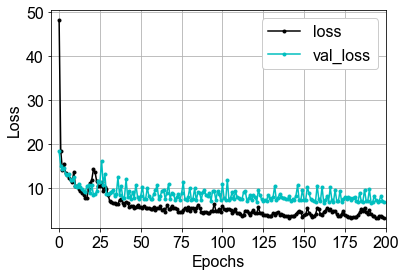

In [46]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5, 200))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
plt.xticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.yticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.legend(loc = 'best', framealpha=1, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs',fontname="Arial", fontsize=16)
plt.ylabel('Loss',fontname="Arial", fontsize=16)
plt.savefig("CNN_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

In [33]:
filepath = 'MRI_CNN.model'
save_model(model, filepath, save_format='h5')

In [25]:
model = load_model('MRI_CNN.model')

In [26]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train set R^2: 0.91
Train MAE score: 3.73
Train RMSE score: 6.76
Test set R^2: 0.77
Test MAE score: 8.21
Test RMSE score: 11.33


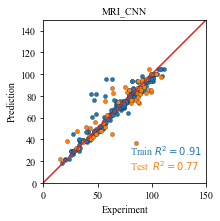

In [36]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_CNN',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_CNN.png", dpi=1200, bbox_inches='tight') 

### Data Fusion

In [23]:
Mix_X = []
for i in range(len(DF_MRI[Flag])):
    Mix_X.append(X.iloc[0].values * DF_MRI[Flag]['TFEA'].iloc[i] + \
                 X.iloc[1].values * DF_MRI[Flag]['HexaFOEA'].iloc[i] + \
                 X.iloc[2].values * DF_MRI[Flag]['NonaFOEA'].iloc[i] + \
                 X.iloc[3].values * DF_MRI[Flag]['PEGA'].iloc[i] + \
                 X.iloc[4].values * DF_MRI[Flag]['HEA'].iloc[i] + \
                 X.iloc[5].values * DF_MRI[Flag]['MSEA'].iloc[i])
Mix_X = np.array(Mix_X)

In [24]:
Mix_X.shape

(271, 80)

In [25]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)
        
        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = 0
            elif j in Random_position[1]:
                Sequency_X[j] = 1
            elif j in Random_position[2]:
                Sequency_X[j] = 2
            elif j in Random_position[3]:
                Sequency_X[j] = 3
            elif j in Random_position[4]:
                Sequency_X[j] = 4
            elif j in Random_position[5]:
                Sequency_X[j] = 5
                
        Mix_X_100Block.append(Sequency_X)   

Mix_X_100Block = np.array(Mix_X_100Block)

In [26]:
Mix_X_100Block.shape

(271, 100)

In [27]:
Mix_X_100Block = Mix_X_100Block.reshape((271, 100, 1))
Mix_X_100Block.shape

(271, 100, 1)

In [28]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import Concatenate
from numpy.random import seed
import tensorflow

In [29]:
LSTMunits = 20

In [30]:
# define two sets of inputs
inputA = Input(shape=(100,1))
inputB = Input(shape=(80))
# the first branch operates on the first input

RNNmodel = Sequential()
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100,1)))
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
RNNmodel.add(TimeDistributed(Dense(int(LSTMunits/2), activation="relu")))
RNNmodel.add(Reshape((int(LSTMunits/2*100),)))

# the second branch opreates on the second input
y = Dense(8, activation="relu")(inputB)
y = Dense(8, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = Concatenate()([RNNmodel.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(8, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[RNNmodel.input, y.input], outputs=z)


xtrain_B, xtest_B, ytrain_B, ytest_B=train_test_split(Mix_X, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.20, random_state=200)
xtrain_A, xtest_A, ytrain_A, ytest_A=train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.20, random_state=200)

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss="mean_squared_error",
              metrics=["mean_squared_error"])

Model = model.fit(
    x=[xtrain_A, xtrain_B], y=ytrain_B,
    validation_data=([xtest_A, xtest_B], ytest_B),
    epochs=300, batch_size=32, verbose=2) #epochs=100, batch_size=128, verbose=2)

Epoch 1/300
7/7 - 1s - loss: 5120.5601 - mean_squared_error: 5120.5601 - val_loss: 5402.3750 - val_mean_squared_error: 5402.3750
Epoch 2/300
7/7 - 0s - loss: 4305.8198 - mean_squared_error: 4305.8198 - val_loss: 3963.5012 - val_mean_squared_error: 3963.5012
Epoch 3/300
7/7 - 0s - loss: 2693.9287 - mean_squared_error: 2693.9287 - val_loss: 1924.7507 - val_mean_squared_error: 1924.7509
Epoch 4/300
7/7 - 0s - loss: 985.7461 - mean_squared_error: 985.7461 - val_loss: 624.9214 - val_mean_squared_error: 624.9214
Epoch 5/300
7/7 - 0s - loss: 552.6452 - mean_squared_error: 552.6452 - val_loss: 726.8588 - val_mean_squared_error: 726.8588
Epoch 6/300
7/7 - 0s - loss: 664.6360 - mean_squared_error: 664.6360 - val_loss: 595.7104 - val_mean_squared_error: 595.7104
Epoch 7/300
7/7 - 0s - loss: 494.2893 - mean_squared_error: 494.2893 - val_loss: 655.4172 - val_mean_squared_error: 655.4172
Epoch 8/300
7/7 - 0s - loss: 519.1539 - mean_squared_error: 519.1539 - val_loss: 673.0013 - val_mean_squared_erro

Epoch 66/300
7/7 - 0s - loss: 194.8005 - mean_squared_error: 194.8005 - val_loss: 189.4932 - val_mean_squared_error: 189.4932
Epoch 67/300
7/7 - 0s - loss: 200.3340 - mean_squared_error: 200.3340 - val_loss: 187.4031 - val_mean_squared_error: 187.4031
Epoch 68/300
7/7 - 0s - loss: 198.4619 - mean_squared_error: 198.4619 - val_loss: 207.8110 - val_mean_squared_error: 207.8110
Epoch 69/300
7/7 - 0s - loss: 195.1798 - mean_squared_error: 195.1798 - val_loss: 187.3118 - val_mean_squared_error: 187.3118
Epoch 70/300
7/7 - 0s - loss: 195.5942 - mean_squared_error: 195.5942 - val_loss: 185.7527 - val_mean_squared_error: 185.7527
Epoch 71/300
7/7 - 0s - loss: 194.3468 - mean_squared_error: 194.3468 - val_loss: 196.0935 - val_mean_squared_error: 196.0935
Epoch 72/300
7/7 - 0s - loss: 193.9270 - mean_squared_error: 193.9270 - val_loss: 182.5683 - val_mean_squared_error: 182.5683
Epoch 73/300
7/7 - 0s - loss: 192.3940 - mean_squared_error: 192.3940 - val_loss: 187.9758 - val_mean_squared_error: 1

Epoch 131/300
7/7 - 0s - loss: 167.7047 - mean_squared_error: 167.7047 - val_loss: 135.0235 - val_mean_squared_error: 135.0235
Epoch 132/300
7/7 - 0s - loss: 163.7250 - mean_squared_error: 163.7250 - val_loss: 141.6844 - val_mean_squared_error: 141.6844
Epoch 133/300
7/7 - 0s - loss: 160.2484 - mean_squared_error: 160.2484 - val_loss: 132.0378 - val_mean_squared_error: 132.0378
Epoch 134/300
7/7 - 0s - loss: 163.2269 - mean_squared_error: 163.2269 - val_loss: 133.1223 - val_mean_squared_error: 133.1223
Epoch 135/300
7/7 - 0s - loss: 165.8349 - mean_squared_error: 165.8349 - val_loss: 134.1761 - val_mean_squared_error: 134.1761
Epoch 136/300
7/7 - 0s - loss: 161.3339 - mean_squared_error: 161.3339 - val_loss: 131.4953 - val_mean_squared_error: 131.4953
Epoch 137/300
7/7 - 0s - loss: 154.3299 - mean_squared_error: 154.3299 - val_loss: 138.6519 - val_mean_squared_error: 138.6519
Epoch 138/300
7/7 - 0s - loss: 161.4477 - mean_squared_error: 161.4477 - val_loss: 127.8494 - val_mean_squared_

Epoch 196/300
7/7 - 0s - loss: 116.9863 - mean_squared_error: 116.9863 - val_loss: 106.2228 - val_mean_squared_error: 106.2228
Epoch 197/300
7/7 - 0s - loss: 117.0961 - mean_squared_error: 117.0961 - val_loss: 106.9123 - val_mean_squared_error: 106.9123
Epoch 198/300
7/7 - 0s - loss: 123.6219 - mean_squared_error: 123.6219 - val_loss: 108.0678 - val_mean_squared_error: 108.0678
Epoch 199/300
7/7 - 0s - loss: 116.4410 - mean_squared_error: 116.4410 - val_loss: 104.3948 - val_mean_squared_error: 104.3948
Epoch 200/300
7/7 - 0s - loss: 115.1849 - mean_squared_error: 115.1849 - val_loss: 102.9129 - val_mean_squared_error: 102.9129
Epoch 201/300
7/7 - 0s - loss: 112.2840 - mean_squared_error: 112.2840 - val_loss: 104.3632 - val_mean_squared_error: 104.3632
Epoch 202/300
7/7 - 0s - loss: 112.1066 - mean_squared_error: 112.1066 - val_loss: 104.5409 - val_mean_squared_error: 104.5409
Epoch 203/300
7/7 - 0s - loss: 115.1140 - mean_squared_error: 115.1140 - val_loss: 107.1651 - val_mean_squared_

7/7 - 0s - loss: 67.3447 - mean_squared_error: 67.3447 - val_loss: 109.0208 - val_mean_squared_error: 109.0208
Epoch 262/300
7/7 - 0s - loss: 69.8876 - mean_squared_error: 69.8876 - val_loss: 103.2980 - val_mean_squared_error: 103.2980
Epoch 263/300
7/7 - 0s - loss: 67.6197 - mean_squared_error: 67.6197 - val_loss: 108.7109 - val_mean_squared_error: 108.7109
Epoch 264/300
7/7 - 0s - loss: 70.3738 - mean_squared_error: 70.3738 - val_loss: 114.4844 - val_mean_squared_error: 114.4844
Epoch 265/300
7/7 - 0s - loss: 71.0919 - mean_squared_error: 71.0919 - val_loss: 111.1550 - val_mean_squared_error: 111.1550
Epoch 266/300
7/7 - 0s - loss: 66.4423 - mean_squared_error: 66.4423 - val_loss: 107.9003 - val_mean_squared_error: 107.9003
Epoch 267/300
7/7 - 0s - loss: 66.5148 - mean_squared_error: 66.5148 - val_loss: 106.2459 - val_mean_squared_error: 106.2459
Epoch 268/300
7/7 - 0s - loss: 66.3787 - mean_squared_error: 66.3787 - val_loss: 119.0577 - val_mean_squared_error: 119.0577
Epoch 269/300


In [67]:
with open('Fusion_Loss.pickle', 'wb') as handle:
    pickle.dump(Model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
Model.history = pickle.load(open("Fusion_Loss.pickle","rb"))

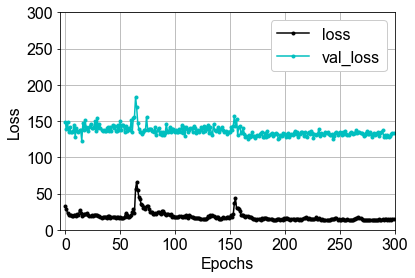

In [78]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5, 300))
plt.ylim((0, 300))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
plt.xticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.yticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.legend(loc = 'best', framealpha=1, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs',fontname="Arial", fontsize=16)
plt.ylabel('Loss',fontname="Arial", fontsize=16)
plt.savefig("Fusion_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

In [47]:
filepath = 'MRI_FusionModel.model'
save_model(model, filepath, save_format='h5')

In [79]:
model = load_model('MRI_FusionModel.model')

In [31]:
y_train = ytrain_B
y_test = ytest_B

y_pred_train = model.predict([xtrain_A, xtrain_B])
print("Train set R^2: ", r2_score(y_train, y_pred_train))

y_pred_test = model.predict([xtest_A, xtest_B])
print("Test set R^2: ", r2_score(y_test, y_pred_test))

Train set R^2:  0.9029361960625842
Test set R^2:  0.8121163869626837


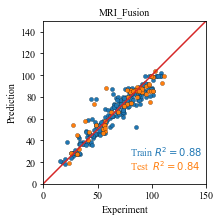

In [156]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_Fusion',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_FusionModel.png", dpi=1200, bbox_inches='tight') 

### FFNN

In [32]:
Mix_X = []
for i in range(len(DF_MRI[Flag])):
    Mix_X.append(X.iloc[0].values * DF_MRI[Flag]['TFEA'].iloc[i] + \
                 X.iloc[1].values * DF_MRI[Flag]['HexaFOEA'].iloc[i] + \
                 X.iloc[2].values * DF_MRI[Flag]['NonaFOEA'].iloc[i] + \
                 X.iloc[3].values * DF_MRI[Flag]['PEGA'].iloc[i] + \
                 X.iloc[4].values * DF_MRI[Flag]['HEA'].iloc[i] + \
                 X.iloc[5].values * DF_MRI[Flag]['MSEA'].iloc[i])
Mix_X = np.array(Mix_X)

In [33]:
Mix_X.shape

(271, 80)

In [34]:
Mix_X

array([[1. , 0. , 0. , ..., 0. , 0.9, 0. ],
       [1. , 0.5, 0. , ..., 0. , 0.3, 0. ],
       [1. , 0. , 0. , ..., 0. , 0.3, 0. ],
       ...,
       [1. , 0. , 0. , ..., 0.6, 0.4, 0. ],
       [1. , 0. , 0. , ..., 0.6, 0.4, 0. ],
       [1. , 0. , 0. , ..., 0.7, 0.3, 0. ]])

In [35]:
x_train, x_test, y_train, y_test = train_test_split(Mix_X, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=11)

In [36]:
model = keras.models.Sequential()
model.add(Dense(units = 24, input_dim = x_train.shape[1],activation='relu'))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="mean_squared_error",
              metrics=["mean_squared_error"])
Model = model.fit(x_train, y_train, epochs = 1000, batch_size = 128,
            validation_data = (x_test, y_test), verbose=2)

Epoch 1/1000
2/2 - 0s - loss: 5149.1191 - mean_squared_error: 5149.1191 - val_loss: 6177.8447 - val_mean_squared_error: 6177.8447
Epoch 2/1000
2/2 - 0s - loss: 5120.7524 - mean_squared_error: 5120.7524 - val_loss: 6142.8306 - val_mean_squared_error: 6142.8306
Epoch 3/1000
2/2 - 0s - loss: 5089.5396 - mean_squared_error: 5089.5396 - val_loss: 6103.1748 - val_mean_squared_error: 6103.1748
Epoch 4/1000
2/2 - 0s - loss: 5054.0806 - mean_squared_error: 5054.0806 - val_loss: 6060.0840 - val_mean_squared_error: 6060.0840
Epoch 5/1000
2/2 - 0s - loss: 5015.7417 - mean_squared_error: 5015.7417 - val_loss: 6013.5454 - val_mean_squared_error: 6013.5454
Epoch 6/1000
2/2 - 0s - loss: 4973.3491 - mean_squared_error: 4973.3496 - val_loss: 5962.4546 - val_mean_squared_error: 5962.4546
Epoch 7/1000
2/2 - 0s - loss: 4928.0342 - mean_squared_error: 4928.0342 - val_loss: 5906.1084 - val_mean_squared_error: 5906.1084
Epoch 8/1000
2/2 - 0s - loss: 4877.9551 - mean_squared_error: 4877.9551 - val_loss: 5843.7

Epoch 65/1000
2/2 - 0s - loss: 294.0992 - mean_squared_error: 294.0992 - val_loss: 267.2735 - val_mean_squared_error: 267.2735
Epoch 66/1000
2/2 - 0s - loss: 293.0361 - mean_squared_error: 293.0361 - val_loss: 267.1699 - val_mean_squared_error: 267.1699
Epoch 67/1000
2/2 - 0s - loss: 292.1739 - mean_squared_error: 292.1738 - val_loss: 266.5024 - val_mean_squared_error: 266.5024
Epoch 68/1000
2/2 - 0s - loss: 291.2907 - mean_squared_error: 291.2907 - val_loss: 265.1890 - val_mean_squared_error: 265.1890
Epoch 69/1000
2/2 - 0s - loss: 290.2918 - mean_squared_error: 290.2918 - val_loss: 263.6664 - val_mean_squared_error: 263.6664
Epoch 70/1000
2/2 - 0s - loss: 289.2190 - mean_squared_error: 289.2190 - val_loss: 262.1450 - val_mean_squared_error: 262.1450
Epoch 71/1000
2/2 - 0s - loss: 288.2454 - mean_squared_error: 288.2454 - val_loss: 260.4456 - val_mean_squared_error: 260.4456
Epoch 72/1000
2/2 - 0s - loss: 287.2667 - mean_squared_error: 287.2667 - val_loss: 258.7424 - val_mean_squared_

Epoch 130/1000
2/2 - 0s - loss: 246.7040 - mean_squared_error: 246.7040 - val_loss: 211.9425 - val_mean_squared_error: 211.9425
Epoch 131/1000
2/2 - 0s - loss: 246.1660 - mean_squared_error: 246.1660 - val_loss: 211.5406 - val_mean_squared_error: 211.5406
Epoch 132/1000
2/2 - 0s - loss: 245.6883 - mean_squared_error: 245.6883 - val_loss: 211.1806 - val_mean_squared_error: 211.1806
Epoch 133/1000
2/2 - 0s - loss: 245.2231 - mean_squared_error: 245.2231 - val_loss: 211.0454 - val_mean_squared_error: 211.0454
Epoch 134/1000
2/2 - 0s - loss: 244.7470 - mean_squared_error: 244.7470 - val_loss: 210.6545 - val_mean_squared_error: 210.6545
Epoch 135/1000
2/2 - 0s - loss: 244.3302 - mean_squared_error: 244.3302 - val_loss: 210.2353 - val_mean_squared_error: 210.2353
Epoch 136/1000
2/2 - 0s - loss: 243.8458 - mean_squared_error: 243.8458 - val_loss: 210.2720 - val_mean_squared_error: 210.2720
Epoch 137/1000
2/2 - 0s - loss: 243.3546 - mean_squared_error: 243.3546 - val_loss: 210.1117 - val_mean_

Epoch 195/1000
2/2 - 0s - loss: 224.9482 - mean_squared_error: 224.9482 - val_loss: 187.6868 - val_mean_squared_error: 187.6868
Epoch 196/1000
2/2 - 0s - loss: 224.7349 - mean_squared_error: 224.7349 - val_loss: 187.0304 - val_mean_squared_error: 187.0304
Epoch 197/1000
2/2 - 0s - loss: 224.4926 - mean_squared_error: 224.4926 - val_loss: 186.6628 - val_mean_squared_error: 186.6628
Epoch 198/1000
2/2 - 0s - loss: 224.3835 - mean_squared_error: 224.3835 - val_loss: 186.0186 - val_mean_squared_error: 186.0186
Epoch 199/1000
2/2 - 0s - loss: 224.0524 - mean_squared_error: 224.0524 - val_loss: 185.8984 - val_mean_squared_error: 185.8984
Epoch 200/1000
2/2 - 0s - loss: 223.9188 - mean_squared_error: 223.9188 - val_loss: 185.6880 - val_mean_squared_error: 185.6880
Epoch 201/1000
2/2 - 0s - loss: 223.6675 - mean_squared_error: 223.6675 - val_loss: 185.7718 - val_mean_squared_error: 185.7718
Epoch 202/1000
2/2 - 0s - loss: 223.4423 - mean_squared_error: 223.4423 - val_loss: 185.9151 - val_mean_

Epoch 260/1000
2/2 - 0s - loss: 214.3379 - mean_squared_error: 214.3379 - val_loss: 174.2537 - val_mean_squared_error: 174.2537
Epoch 261/1000
2/2 - 0s - loss: 214.2279 - mean_squared_error: 214.2279 - val_loss: 174.3071 - val_mean_squared_error: 174.3071
Epoch 262/1000
2/2 - 0s - loss: 214.1971 - mean_squared_error: 214.1971 - val_loss: 174.2337 - val_mean_squared_error: 174.2337
Epoch 263/1000
2/2 - 0s - loss: 213.9671 - mean_squared_error: 213.9671 - val_loss: 173.2092 - val_mean_squared_error: 173.2092
Epoch 264/1000
2/2 - 0s - loss: 213.8352 - mean_squared_error: 213.8352 - val_loss: 172.5052 - val_mean_squared_error: 172.5052
Epoch 265/1000
2/2 - 0s - loss: 213.7164 - mean_squared_error: 213.7164 - val_loss: 171.5615 - val_mean_squared_error: 171.5615
Epoch 266/1000
2/2 - 0s - loss: 213.7769 - mean_squared_error: 213.7769 - val_loss: 170.1373 - val_mean_squared_error: 170.1373
Epoch 267/1000
2/2 - 0s - loss: 213.6057 - mean_squared_error: 213.6057 - val_loss: 169.5237 - val_mean_

2/2 - 0s - loss: 208.2645 - mean_squared_error: 208.2645 - val_loss: 161.8808 - val_mean_squared_error: 161.8808
Epoch 325/1000
2/2 - 0s - loss: 208.3968 - mean_squared_error: 208.3968 - val_loss: 162.8774 - val_mean_squared_error: 162.8774
Epoch 326/1000
2/2 - 0s - loss: 208.0976 - mean_squared_error: 208.0976 - val_loss: 162.9883 - val_mean_squared_error: 162.9883
Epoch 327/1000
2/2 - 0s - loss: 208.0257 - mean_squared_error: 208.0257 - val_loss: 162.6336 - val_mean_squared_error: 162.6336
Epoch 328/1000
2/2 - 0s - loss: 207.9230 - mean_squared_error: 207.9230 - val_loss: 162.8690 - val_mean_squared_error: 162.8690
Epoch 329/1000
2/2 - 0s - loss: 207.8528 - mean_squared_error: 207.8528 - val_loss: 163.1048 - val_mean_squared_error: 163.1048
Epoch 330/1000
2/2 - 0s - loss: 207.7822 - mean_squared_error: 207.7822 - val_loss: 163.2477 - val_mean_squared_error: 163.2477
Epoch 331/1000
2/2 - 0s - loss: 207.7022 - mean_squared_error: 207.7022 - val_loss: 163.0523 - val_mean_squared_error: 

Epoch 389/1000
2/2 - 0s - loss: 204.8432 - mean_squared_error: 204.8432 - val_loss: 155.8755 - val_mean_squared_error: 155.8755
Epoch 390/1000
2/2 - 0s - loss: 204.6465 - mean_squared_error: 204.6465 - val_loss: 156.3097 - val_mean_squared_error: 156.3097
Epoch 391/1000
2/2 - 0s - loss: 204.6181 - mean_squared_error: 204.6181 - val_loss: 157.3149 - val_mean_squared_error: 157.3149
Epoch 392/1000
2/2 - 0s - loss: 204.5581 - mean_squared_error: 204.5581 - val_loss: 157.8628 - val_mean_squared_error: 157.8628
Epoch 393/1000
2/2 - 0s - loss: 204.8031 - mean_squared_error: 204.8031 - val_loss: 158.8740 - val_mean_squared_error: 158.8740
Epoch 394/1000
2/2 - 0s - loss: 204.4831 - mean_squared_error: 204.4831 - val_loss: 158.3983 - val_mean_squared_error: 158.3983
Epoch 395/1000
2/2 - 0s - loss: 204.4489 - mean_squared_error: 204.4489 - val_loss: 157.7287 - val_mean_squared_error: 157.7287
Epoch 396/1000
2/2 - 0s - loss: 204.4064 - mean_squared_error: 204.4064 - val_loss: 157.1824 - val_mean_

Epoch 454/1000
2/2 - 0s - loss: 203.0369 - mean_squared_error: 203.0369 - val_loss: 156.2416 - val_mean_squared_error: 156.2416
Epoch 455/1000
2/2 - 0s - loss: 202.9681 - mean_squared_error: 202.9681 - val_loss: 154.8365 - val_mean_squared_error: 154.8365
Epoch 456/1000
2/2 - 0s - loss: 202.9883 - mean_squared_error: 202.9883 - val_loss: 153.5151 - val_mean_squared_error: 153.5151
Epoch 457/1000
2/2 - 0s - loss: 202.9800 - mean_squared_error: 202.9800 - val_loss: 152.7471 - val_mean_squared_error: 152.7471
Epoch 458/1000
2/2 - 0s - loss: 202.9399 - mean_squared_error: 202.9399 - val_loss: 152.7801 - val_mean_squared_error: 152.7801
Epoch 459/1000
2/2 - 0s - loss: 202.9351 - mean_squared_error: 202.9351 - val_loss: 152.8466 - val_mean_squared_error: 152.8466
Epoch 460/1000
2/2 - 0s - loss: 202.9048 - mean_squared_error: 202.9048 - val_loss: 152.5773 - val_mean_squared_error: 152.5773
Epoch 461/1000
2/2 - 0s - loss: 202.9452 - mean_squared_error: 202.9452 - val_loss: 152.5178 - val_mean_

Epoch 519/1000
2/2 - 0s - loss: 202.3841 - mean_squared_error: 202.3841 - val_loss: 150.9349 - val_mean_squared_error: 150.9349
Epoch 520/1000
2/2 - 0s - loss: 202.3731 - mean_squared_error: 202.3731 - val_loss: 151.4474 - val_mean_squared_error: 151.4474
Epoch 521/1000
2/2 - 0s - loss: 202.3454 - mean_squared_error: 202.3454 - val_loss: 152.0626 - val_mean_squared_error: 152.0626
Epoch 522/1000
2/2 - 0s - loss: 202.4184 - mean_squared_error: 202.4184 - val_loss: 152.8539 - val_mean_squared_error: 152.8539
Epoch 523/1000
2/2 - 0s - loss: 202.5845 - mean_squared_error: 202.5845 - val_loss: 152.3679 - val_mean_squared_error: 152.3679
Epoch 524/1000
2/2 - 0s - loss: 202.3484 - mean_squared_error: 202.3484 - val_loss: 153.0911 - val_mean_squared_error: 153.0911
Epoch 525/1000
2/2 - 0s - loss: 202.3091 - mean_squared_error: 202.3091 - val_loss: 154.4227 - val_mean_squared_error: 154.4227
Epoch 526/1000
2/2 - 0s - loss: 202.4319 - mean_squared_error: 202.4319 - val_loss: 155.5426 - val_mean_

Epoch 584/1000
2/2 - 0s - loss: 202.1733 - mean_squared_error: 202.1733 - val_loss: 149.5513 - val_mean_squared_error: 149.5513
Epoch 585/1000
2/2 - 0s - loss: 202.1858 - mean_squared_error: 202.1858 - val_loss: 150.5110 - val_mean_squared_error: 150.5110
Epoch 586/1000
2/2 - 0s - loss: 202.1494 - mean_squared_error: 202.1494 - val_loss: 151.1703 - val_mean_squared_error: 151.1703
Epoch 587/1000
2/2 - 0s - loss: 202.2120 - mean_squared_error: 202.2120 - val_loss: 151.8465 - val_mean_squared_error: 151.8465
Epoch 588/1000
2/2 - 0s - loss: 202.1414 - mean_squared_error: 202.1414 - val_loss: 151.7297 - val_mean_squared_error: 151.7297
Epoch 589/1000
2/2 - 0s - loss: 202.1366 - mean_squared_error: 202.1366 - val_loss: 151.2733 - val_mean_squared_error: 151.2733
Epoch 590/1000
2/2 - 0s - loss: 202.1972 - mean_squared_error: 202.1972 - val_loss: 150.6754 - val_mean_squared_error: 150.6754
Epoch 591/1000
2/2 - 0s - loss: 202.1480 - mean_squared_error: 202.1480 - val_loss: 150.7558 - val_mean_

Epoch 649/1000
2/2 - 0s - loss: 202.1043 - mean_squared_error: 202.1043 - val_loss: 151.7087 - val_mean_squared_error: 151.7087
Epoch 650/1000
2/2 - 0s - loss: 202.0816 - mean_squared_error: 202.0816 - val_loss: 150.2634 - val_mean_squared_error: 150.2634
Epoch 651/1000
2/2 - 0s - loss: 202.1824 - mean_squared_error: 202.1824 - val_loss: 148.8937 - val_mean_squared_error: 148.8937
Epoch 652/1000
2/2 - 0s - loss: 202.2218 - mean_squared_error: 202.2218 - val_loss: 149.0583 - val_mean_squared_error: 149.0583
Epoch 653/1000
2/2 - 0s - loss: 202.1607 - mean_squared_error: 202.1607 - val_loss: 148.2895 - val_mean_squared_error: 148.2895
Epoch 654/1000
2/2 - 0s - loss: 202.1440 - mean_squared_error: 202.1440 - val_loss: 148.5263 - val_mean_squared_error: 148.5263
Epoch 655/1000
2/2 - 0s - loss: 202.2338 - mean_squared_error: 202.2338 - val_loss: 149.2133 - val_mean_squared_error: 149.2133
Epoch 656/1000
2/2 - 0s - loss: 202.1704 - mean_squared_error: 202.1704 - val_loss: 148.9843 - val_mean_

Epoch 714/1000
2/2 - 0s - loss: 202.1774 - mean_squared_error: 202.1774 - val_loss: 153.5364 - val_mean_squared_error: 153.5364
Epoch 715/1000
2/2 - 0s - loss: 202.1811 - mean_squared_error: 202.1811 - val_loss: 153.0305 - val_mean_squared_error: 153.0305
Epoch 716/1000
2/2 - 0s - loss: 202.1140 - mean_squared_error: 202.1140 - val_loss: 151.1728 - val_mean_squared_error: 151.1728
Epoch 717/1000
2/2 - 0s - loss: 202.3583 - mean_squared_error: 202.3583 - val_loss: 149.2529 - val_mean_squared_error: 149.2529
Epoch 718/1000
2/2 - 0s - loss: 202.0834 - mean_squared_error: 202.0834 - val_loss: 149.2579 - val_mean_squared_error: 149.2579
Epoch 719/1000
2/2 - 0s - loss: 202.2755 - mean_squared_error: 202.2755 - val_loss: 148.9082 - val_mean_squared_error: 148.9082
Epoch 720/1000
2/2 - 0s - loss: 202.0811 - mean_squared_error: 202.0811 - val_loss: 150.2691 - val_mean_squared_error: 150.2691
Epoch 721/1000
2/2 - 0s - loss: 202.0818 - mean_squared_error: 202.0818 - val_loss: 151.5621 - val_mean_

Epoch 779/1000
2/2 - 0s - loss: 202.2716 - mean_squared_error: 202.2716 - val_loss: 148.9991 - val_mean_squared_error: 148.9991
Epoch 780/1000
2/2 - 0s - loss: 202.1855 - mean_squared_error: 202.1855 - val_loss: 149.0150 - val_mean_squared_error: 149.0150
Epoch 781/1000
2/2 - 0s - loss: 202.0917 - mean_squared_error: 202.0917 - val_loss: 148.3359 - val_mean_squared_error: 148.3359
Epoch 782/1000
2/2 - 0s - loss: 202.1996 - mean_squared_error: 202.1996 - val_loss: 147.2208 - val_mean_squared_error: 147.2208
Epoch 783/1000
2/2 - 0s - loss: 202.1664 - mean_squared_error: 202.1664 - val_loss: 147.4771 - val_mean_squared_error: 147.4771
Epoch 784/1000
2/2 - 0s - loss: 202.1602 - mean_squared_error: 202.1602 - val_loss: 148.9103 - val_mean_squared_error: 148.9103
Epoch 785/1000
2/2 - 0s - loss: 202.0902 - mean_squared_error: 202.0902 - val_loss: 149.7959 - val_mean_squared_error: 149.7959
Epoch 786/1000
2/2 - 0s - loss: 202.0458 - mean_squared_error: 202.0458 - val_loss: 151.3179 - val_mean_

Epoch 844/1000
2/2 - 0s - loss: 202.1962 - mean_squared_error: 202.1962 - val_loss: 150.1452 - val_mean_squared_error: 150.1452
Epoch 845/1000
2/2 - 0s - loss: 202.0743 - mean_squared_error: 202.0743 - val_loss: 149.0679 - val_mean_squared_error: 149.0679
Epoch 846/1000
2/2 - 0s - loss: 202.1367 - mean_squared_error: 202.1367 - val_loss: 148.6609 - val_mean_squared_error: 148.6609
Epoch 847/1000
2/2 - 0s - loss: 202.4124 - mean_squared_error: 202.4124 - val_loss: 147.3778 - val_mean_squared_error: 147.3778
Epoch 848/1000
2/2 - 0s - loss: 202.1959 - mean_squared_error: 202.1959 - val_loss: 148.7031 - val_mean_squared_error: 148.7031
Epoch 849/1000
2/2 - 0s - loss: 202.0945 - mean_squared_error: 202.0945 - val_loss: 149.7693 - val_mean_squared_error: 149.7693
Epoch 850/1000
2/2 - 0s - loss: 202.1221 - mean_squared_error: 202.1221 - val_loss: 151.0616 - val_mean_squared_error: 151.0616
Epoch 851/1000
2/2 - 0s - loss: 202.2927 - mean_squared_error: 202.2927 - val_loss: 151.0233 - val_mean_

Epoch 909/1000
2/2 - 0s - loss: 202.2952 - mean_squared_error: 202.2952 - val_loss: 150.0308 - val_mean_squared_error: 150.0308
Epoch 910/1000
2/2 - 0s - loss: 202.0745 - mean_squared_error: 202.0745 - val_loss: 148.7169 - val_mean_squared_error: 148.7169
Epoch 911/1000
2/2 - 0s - loss: 202.6156 - mean_squared_error: 202.6156 - val_loss: 147.5413 - val_mean_squared_error: 147.5413
Epoch 912/1000
2/2 - 0s - loss: 202.2944 - mean_squared_error: 202.2944 - val_loss: 149.7357 - val_mean_squared_error: 149.7357
Epoch 913/1000
2/2 - 0s - loss: 202.1136 - mean_squared_error: 202.1136 - val_loss: 150.4112 - val_mean_squared_error: 150.4112
Epoch 914/1000
2/2 - 0s - loss: 202.1287 - mean_squared_error: 202.1287 - val_loss: 152.2666 - val_mean_squared_error: 152.2666
Epoch 915/1000
2/2 - 0s - loss: 202.0886 - mean_squared_error: 202.0886 - val_loss: 152.8852 - val_mean_squared_error: 152.8852
Epoch 916/1000
2/2 - 0s - loss: 202.1195 - mean_squared_error: 202.1195 - val_loss: 152.8876 - val_mean_

Epoch 974/1000
2/2 - 0s - loss: 202.0683 - mean_squared_error: 202.0683 - val_loss: 150.5479 - val_mean_squared_error: 150.5479
Epoch 975/1000
2/2 - 0s - loss: 202.1981 - mean_squared_error: 202.1981 - val_loss: 150.6516 - val_mean_squared_error: 150.6516
Epoch 976/1000
2/2 - 0s - loss: 202.0862 - mean_squared_error: 202.0862 - val_loss: 152.2628 - val_mean_squared_error: 152.2628
Epoch 977/1000
2/2 - 0s - loss: 202.0856 - mean_squared_error: 202.0856 - val_loss: 152.7823 - val_mean_squared_error: 152.7823
Epoch 978/1000
2/2 - 0s - loss: 202.3291 - mean_squared_error: 202.3291 - val_loss: 152.4681 - val_mean_squared_error: 152.4681
Epoch 979/1000
2/2 - 0s - loss: 202.1132 - mean_squared_error: 202.1132 - val_loss: 153.7199 - val_mean_squared_error: 153.7199
Epoch 980/1000
2/2 - 0s - loss: 202.1528 - mean_squared_error: 202.1528 - val_loss: 153.6983 - val_mean_squared_error: 153.6983
Epoch 981/1000
2/2 - 0s - loss: 202.1336 - mean_squared_error: 202.1336 - val_loss: 153.0231 - val_mean_

In [99]:
with open('FFNN_Loss.pickle', 'wb') as handle:
    pickle.dump(Model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
Model.history = pickle.load(open("FFNN_Loss.pickle","rb"))

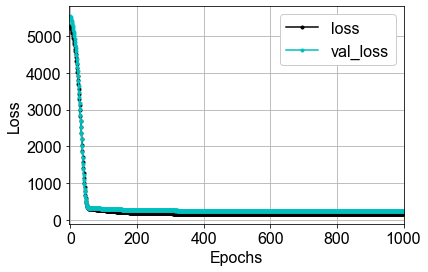

In [98]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5, 1000))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
plt.xticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.yticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.legend(loc = 'best', framealpha=1, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs',fontname="Arial", fontsize=16)
plt.ylabel('Loss',fontname="Arial", fontsize=16)
plt.savefig("FFNN_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

In [57]:
filepath = 'MRI_DNN.model'
save_model(model, filepath, save_format='h5')

In [58]:
model = load_model('MRI_DNN.model')

In [37]:
y_pred_train = model.predict((x_train))
print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict((x_test))
print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train set R^2: 0.61
Train MAE score: 10.97
Train RMSE score: 14.22
Test set R^2: 0.71
Test MAE score: 10.45
Test RMSE score: 12.21


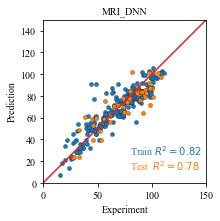

In [172]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_DNN',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_DNN.png", dpi=1200, bbox_inches='tight') 

### RNN

In [38]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, TimeDistributed, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import mean_absolute_error, r2_score

In [39]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)
        
        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = list(X.iloc[0].values)
            elif j in Random_position[1]:
                Sequency_X[j] = list(X.iloc[1].values)
            elif j in Random_position[2]:
                Sequency_X[j] = list(X.iloc[2].values)
            elif j in Random_position[3]:
                Sequency_X[j] = list(X.iloc[3].values)
            elif j in Random_position[4]:
                Sequency_X[j] = list(X.iloc[4].values)
            elif j in Random_position[5]:
                Sequency_X[j] = list(X.iloc[5].values)
                
        Mix_X_100Block.append(Sequency_X)   

Mix_X_100Block = np.array(Mix_X_100Block)

In [40]:
Mix_X_100Block.shape

(271, 100, 80)

In [41]:
Mix_X_100Block

array([[[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       ...,

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0]],

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 

In [42]:
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=11)

In [43]:
def getRNNmodel(LSTMunits):

    RNNmodel = Sequential()
    RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100, 80)))
    RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
    RNNmodel.add(TimeDistributed(Dense(int(LSTMunits/2), activation="relu")))
    RNNmodel.add(Reshape((int(LSTMunits/2*100),)))
    RNNmodel.add(Dense(1))

    return RNNmodel

LSTMunits = 20
RNNmodel = getRNNmodel(LSTMunits)
RNNmodel.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
Model = RNNmodel.fit(X_train, y_train, validation_split=0.2, epochs=200, \
                        batch_size=64)

Epoch 1/200
3/3 [==============================] - 1s 325ms/step - loss: 5292.2534 - mean_squared_error: 5292.2534 - val_loss: 4428.9160 - val_mean_squared_error: 4428.9160
Epoch 2/200
3/3 [==============================] - 0s 52ms/step - loss: 5169.4219 - mean_squared_error: 5169.4219 - val_loss: 4270.5708 - val_mean_squared_error: 4270.5708
Epoch 3/200
3/3 [==============================] - 0s 41ms/step - loss: 4963.3701 - mean_squared_error: 4963.3701 - val_loss: 4040.1243 - val_mean_squared_error: 4040.1243
Epoch 4/200
3/3 [==============================] - 0s 25ms/step - loss: 4677.9995 - mean_squared_error: 4677.9995 - val_loss: 3733.4944 - val_mean_squared_error: 3733.4944
Epoch 5/200
3/3 [==============================] - 0s 26ms/step - loss: 4310.8618 - mean_squared_error: 4310.8618 - val_loss: 3347.9509 - val_mean_squared_error: 3347.9509
Epoch 6/200
3/3 [==============================] - 0s 16ms/step - loss: 3849.7336 - mean_squared_error: 3849.7336 - val_loss: 2886.7219 - v

3/3 [==============================] - 0s 20ms/step - loss: 164.1827 - mean_squared_error: 164.1827 - val_loss: 205.2421 - val_mean_squared_error: 205.2421
Epoch 50/200
3/3 [==============================] - 0s 18ms/step - loss: 159.6210 - mean_squared_error: 159.6210 - val_loss: 201.8635 - val_mean_squared_error: 201.8635
Epoch 51/200
3/3 [==============================] - 0s 15ms/step - loss: 154.6096 - mean_squared_error: 154.6096 - val_loss: 197.8737 - val_mean_squared_error: 197.8737
Epoch 52/200
3/3 [==============================] - 0s 17ms/step - loss: 152.8173 - mean_squared_error: 152.8173 - val_loss: 188.6192 - val_mean_squared_error: 188.6192
Epoch 53/200
3/3 [==============================] - 0s 17ms/step - loss: 148.9049 - mean_squared_error: 148.9049 - val_loss: 190.4959 - val_mean_squared_error: 190.4959
Epoch 54/200
3/3 [==============================] - 0s 17ms/step - loss: 149.1548 - mean_squared_error: 149.1548 - val_loss: 183.8020 - val_mean_squared_error: 183.8020

Epoch 98/200
3/3 [==============================] - 0s 15ms/step - loss: 89.0527 - mean_squared_error: 89.0527 - val_loss: 127.6220 - val_mean_squared_error: 127.6220
Epoch 99/200
3/3 [==============================] - 0s 17ms/step - loss: 84.3656 - mean_squared_error: 84.3656 - val_loss: 116.4766 - val_mean_squared_error: 116.4766
Epoch 100/200
3/3 [==============================] - 0s 16ms/step - loss: 84.7084 - mean_squared_error: 84.7084 - val_loss: 117.8109 - val_mean_squared_error: 117.8109
Epoch 101/200
3/3 [==============================] - 0s 18ms/step - loss: 84.0683 - mean_squared_error: 84.0683 - val_loss: 125.7928 - val_mean_squared_error: 125.7928
Epoch 102/200
3/3 [==============================] - 0s 15ms/step - loss: 80.8284 - mean_squared_error: 80.8284 - val_loss: 124.3554 - val_mean_squared_error: 124.3554
Epoch 103/200
3/3 [==============================] - 0s 17ms/step - loss: 80.6688 - mean_squared_error: 80.6688 - val_loss: 117.9143 - val_mean_squared_error: 117

Epoch 147/200
3/3 [==============================] - 0s 20ms/step - loss: 58.8186 - mean_squared_error: 58.8186 - val_loss: 139.2164 - val_mean_squared_error: 139.2164
Epoch 148/200
3/3 [==============================] - 0s 16ms/step - loss: 57.4221 - mean_squared_error: 57.4221 - val_loss: 127.9926 - val_mean_squared_error: 127.9926
Epoch 149/200
3/3 [==============================] - 0s 17ms/step - loss: 56.2993 - mean_squared_error: 56.2993 - val_loss: 116.1909 - val_mean_squared_error: 116.1909
Epoch 150/200
3/3 [==============================] - 0s 16ms/step - loss: 56.7313 - mean_squared_error: 56.7313 - val_loss: 123.8532 - val_mean_squared_error: 123.8532
Epoch 151/200
3/3 [==============================] - 0s 17ms/step - loss: 56.9173 - mean_squared_error: 56.9173 - val_loss: 130.7818 - val_mean_squared_error: 130.7818
Epoch 152/200
3/3 [==============================] - 0s 17ms/step - loss: 54.1650 - mean_squared_error: 54.1650 - val_loss: 128.4590 - val_mean_squared_error: 1

Epoch 196/200
3/3 [==============================] - 0s 17ms/step - loss: 50.3461 - mean_squared_error: 50.3461 - val_loss: 131.3614 - val_mean_squared_error: 131.3614
Epoch 197/200
3/3 [==============================] - 0s 18ms/step - loss: 43.3484 - mean_squared_error: 43.3484 - val_loss: 128.0845 - val_mean_squared_error: 128.0845
Epoch 198/200
3/3 [==============================] - 0s 14ms/step - loss: 46.3449 - mean_squared_error: 46.3449 - val_loss: 115.5101 - val_mean_squared_error: 115.5101
Epoch 199/200
3/3 [==============================] - 0s 16ms/step - loss: 47.6466 - mean_squared_error: 47.6466 - val_loss: 106.7015 - val_mean_squared_error: 106.7015
Epoch 200/200
3/3 [==============================] - 0s 17ms/step - loss: 40.2571 - mean_squared_error: 40.2571 - val_loss: 114.6486 - val_mean_squared_error: 114.6486


In [109]:
with open('RNN_Loss.pickle', 'wb') as handle:
    pickle.dump(Model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
Model.history = pickle.load(open("RNN_Loss.pickle","rb"))

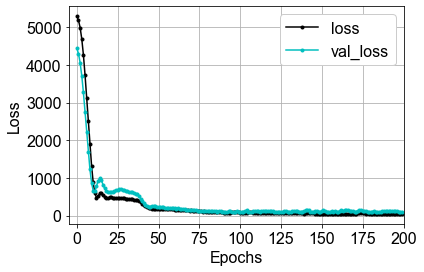

In [108]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5, 200))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
plt.xticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.yticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.legend(loc = 'best', framealpha=1, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs',fontname="Arial", fontsize=16)
plt.ylabel('Loss',fontname="Arial", fontsize=16)
plt.savefig("RNN_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

In [209]:
filepath = 'MRI_RNN.model'
save_model(RNNmodel, filepath, save_format='h5')

In [32]:
RNNmodel = load_model('MRI_RNN.model')

In [44]:
y_pred_train = RNNmodel.predict((X_train))
print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = RNNmodel.predict((X_test))
print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train set R^2: 0.89
Train MAE score: 5.37
Train RMSE score: 7.53
Test set R^2: 0.78
Test MAE score: 8.31
Test RMSE score: 10.52


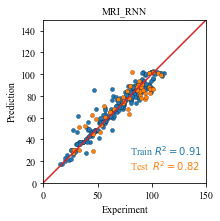

In [142]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_RNN',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_RNN.png", dpi=1200, bbox_inches='tight') 